In [1]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
#from lib.utils import matrics_rotate
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
from lib.utils import import_data, get_split_indexer 

In [3]:


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [35]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
structures = pd.read_csv('../input/structures.csv')

In [36]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [37]:
test_id = test.id.values

In [38]:
ls -l ../submit/v003_022/

total 1513760
-rw-r--r--  1 kenichi.matsui  1522739515  67161316  6 23 01:52 blending_v003_022_7seeds.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67161209  6 23 01:59 blending_v003_022_8seeds.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67162247  6 24 01:20 blending_v003_024_10seeds.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67159342  6 22 11:09 submission_t_v003_022_1.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67161469  6 22 11:09 submission_t_v003_022_143.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67160036  6 23 01:38 submission_t_v003_022_185.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67160687  6 23 01:38 submission_t_v003_022_2457.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67160376  6 23 01:38 submission_t_v003_022_3759.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67162074  6 23 01:38 submission_t_v003_022_3977.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67161761  6 22 11:09 submission_t_v003_022_4039.csv


In [40]:
sub_files = np.sort(glob("../submit/v003_024/submission_t_v003_024_*.csv")).tolist()
#sub_files += ["../submit/v003_021/submission_t_v003_021.csv"]
len(sub_files)

14

In [41]:
sub_files

['../submit/v003_024/submission_t_v003_024_0.csv',
 '../submit/v003_024/submission_t_v003_024_1.csv',
 '../submit/v003_024/submission_t_v003_024_1228.csv',
 '../submit/v003_024/submission_t_v003_024_1229.csv',
 '../submit/v003_024/submission_t_v003_024_1879.csv',
 '../submit/v003_024/submission_t_v003_024_1880.csv',
 '../submit/v003_024/submission_t_v003_024_1988.csv',
 '../submit/v003_024/submission_t_v003_024_1989.csv',
 '../submit/v003_024/submission_t_v003_024_2019.csv',
 '../submit/v003_024/submission_t_v003_024_2020.csv',
 '../submit/v003_024/submission_t_v003_024_71.csv',
 '../submit/v003_024/submission_t_v003_024_72.csv',
 '../submit/v003_024/submission_t_v003_024_92.csv',
 '../submit/v003_024/submission_t_v003_024_93.csv']

In [42]:
sub_list = [pd.read_csv(f, index_col=0).loc[test_id] for f in sub_files]

In [43]:
submit_list_df = pd.concat(sub_list, axis=1)
submit_list_df["mean_score"] = submit_list_df.mean(axis=1).values

In [44]:
submit_list_df.shape, test.shape

((2505542, 15), (2505542, 5))

In [45]:
submit_list_df.head()

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score
id,,,,,,,,,,,,,,,
4658147,14.42941,17.94441,17.13644,15.27704,15.10848,11.30809,16.10830,10.45234,15.45748,14.73881,16.53874,11.38786,11.89966,13.16861,14.35398
4658148,185.88040,189.22815,177.96684,178.29521,189.48546,172.57653,185.81137,172.15734,190.59805,176.24125,176.38060,188.38959,189.59037,190.87225,183.10524
4658149,3.09688,2.21603,1.15874,1.07824,1.08236,2.05203,1.18298,1.41101,1.70897,1.95319,1.59662,1.80854,1.79195,2.19322,1.73791
4658150,185.21704,187.47601,177.79644,177.43159,187.79254,172.67824,185.47784,173.02363,189.29749,175.51608,175.36830,187.60289,188.22205,191.36174,182.44728
4658151,11.23099,11.92204,10.61515,9.89115,10.09855,8.92606,10.62795,8.22679,10.08616,11.51516,10.00420,10.12544,10.47740,7.81167,10.11134


In [46]:
submit_list_df.iloc[:, :len(sub_files)].corr()

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant
scalar_coupling_constant,1.00000,0.99997,0.99997,0.99997,0.99997,0.99996,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99996
scalar_coupling_constant,0.99997,1.00000,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99996,0.99997
scalar_coupling_constant,0.99997,0.99997,1.00000,0.99997,0.99998,0.99997,0.99998,0.99997,0.99997,0.99997,0.99998,0.99997,0.99997,0.99997
scalar_coupling_constant,0.99997,0.99997,0.99997,1.00000,0.99997,0.99998,0.99997,0.99998,0.99997,0.99997,0.99997,0.99998,0.99997,0.99997
scalar_coupling_constant,0.99997,0.99997,0.99998,0.99997,1.00000,0.99997,0.99998,0.99997,0.99997,0.99997,0.99997,0.99997,0.99998,0.99997
scalar_coupling_constant,0.99996,0.99997,0.99997,0.99998,0.99997,1.00000,0.99997,0.99998,0.99997,0.99997,0.99997,0.99997,0.99997,0.99998
scalar_coupling_constant,0.99997,0.99997,0.99998,0.99997,0.99998,0.99997,1.00000,0.99997,0.99997,0.99997,0.99998,0.99997,0.99998,0.99997
scalar_coupling_constant,0.99997,0.99997,0.99997,0.99998,0.99997,0.99998,0.99997,1.00000,0.99997,0.99997,0.99997,0.99998,0.99997,0.99998
scalar_coupling_constant,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,1.00000,0.99997,0.99998,0.99997,0.99997,0.99997
scalar_coupling_constant,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,1.00000,0.99997,0.99998,0.99997,0.99997


In [47]:
sampled_id = submit_list_df.sample(frac=0.1).index.values

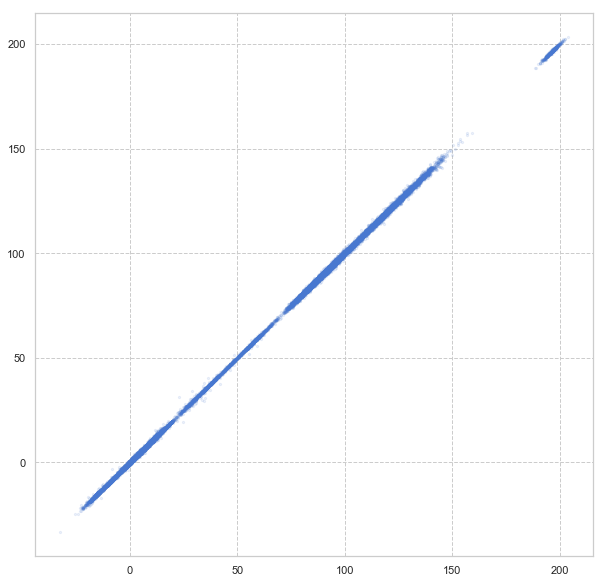

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(x=submit_list_df.iloc[:, 0].loc[sampled_id], 
            y=submit_list_df.iloc[:, 8].loc[sampled_id], alpha=0.1, s= 5)

In [48]:
submit_df = submit_list_df[["mean_score"]]
submit_df.columns = ["scalar_coupling_constant"]

In [49]:
submit_df.head()

,scalar_coupling_constant
id,
4658147,14.35398
4658148,183.10524
4658149,1.73791
4658150,182.44728
4658151,10.11134


In [50]:
Path("../submit/ensemble").mkdir(parents=True, exist_ok=True)

In [51]:
submit_df.to_csv(f'../submit/v003_024/blending_v003_024_14seeds.csv', index=True)

In [52]:
# !kaggle competitions submit -c champs-scalar-coupling -f ../submit/v003_024/blending_v003_024_14seeds.csv -m "blending all data v003_024 14 seeds."

100%|██████████████████████████████████████| 64.0M/64.0M [00:10<00:00, 6.17MB/s]
Successfully submitted to Predicting Molecular Properties